# Notebook pro předbězný výpočet logitů

V tomto notebooku se provádí výpočet logitů "učitelským" modelem dopředu. Důvod je jednoduchý, při učení formou distilace by se opakovaně logity počítaly, a tím by se učení zbytečně prodlužovalo. Logity tedy napočítáme dopředu a uložíme je k datasetu.
Nejprve doinstalujeme knihovny, které nejsou v základu v imagy pro pytorch s GPU podporou na metacentu jupyter hub serveru v základu k dispozici.

In [2]:
%pip install transformers[torch] datasets ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 273.5 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.9
    Uninstalling dill-0.3.9:
      Successfully uninstalled dill-0.3.9

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Následuje import využívaných knihoven

In [3]:
from transformers import AutoModelForImageClassification
from torchvision.transforms import v2 as transformsv2
from torch.utils.data import Dataset
import numpy as np
import pickle
import random
import torch
import os
from tqdm.notebook import tqdm
from PIL import Image


Třídy pro načtení datasetů "ručně" chceme totiž pracovat s datech v jednotlivých souborech, ne s datasetem jako takovým. 

Předpokládá se již stažení datasetů. Případně je možné datasety stáhnout pomocí:

torchvision.dataset.CIFAR10(root='./data/train', train=True, download=True, transform=transform)

Samozřejmě je třeba úprava parametrů dle požadavků.

In [44]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and will be used:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU.")

GPU is available and will be used: NVIDIA A100 80GB PCIe MIG 1g.10gb


In [86]:
def reset_seed(seed=42):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

In [87]:
reset_seed(42)

In [132]:
class CustomCIFAR10(Dataset):
    def __init__(self, root, batch=None, train=True, transform=None, target_transform=None):
        self.root = root
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        

        if self.train:
            self.data_file = os.path.join(self.root, 'cifar-10-batches-py', f'data_batch_{batch}')
        else:
            self.data_file = os.path.join(self.root, 'cifar-10-batches-py', 'test_batch')

        with open(self.data_file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
            self.data = dict[b'data']
            self.labels = dict[b'labels']
        reset_seed(42)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index].reshape(3, 32, 32).transpose(1, 2, 0)
        label = torch.as_tensor(self.labels[index])
        

        image = Image.fromarray(image.astype('uint8'), 'RGB')
        if self.transform:            
            torch.manual_seed(index)
            image = self.transform(image)

        if self.target_transform:
            target = self.target_transform(target)

        return  image.to(device), label.to(device)

In [128]:
class CustomCIFAR100(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.root = root
        self.train = train
        self.transform = transform

        if self.train:
            self.data_file = os.path.join(self.root, 'cifar-100-python', 'train')
        else:
            self.data_file = os.path.join(self.root, 'cifar-100-python', 'test')

        with open(self.data_file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
            self.data = dict[b'data']
            self.labels = dict[b'fine_labels']


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index].reshape(3, 32, 32).transpose(1, 2, 0)
        label = self.labels[index]
        

        image = Image.fromarray(image.astype('uint8'), 'RGB')
        if self.transform:
            image = self.transform(image)
            
        return  image.to(device), label.to(device)

Načtení datasetů a transformace do velikosti, na které byl učitelský, ale i studentský model naučen.

Připraveno jak pro CIFAR10 i CIFAR100, stačí upravit komentáře. Stejné platí i pro dataloader, kde se train v případě CIFAR10 nevyužije (rozpad datasetu do několika souborů).

In [113]:
reset_seed(42)

In [114]:
transform = transformsv2.Compose([
    transformsv2.ToImage(),
    transformsv2.ToDtype(torch.float32, scale=True),
    transformsv2.Resize((224, 224)),
    transformsv2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
reset_seed(42)
#Teoretické random augmentace - bude nutné uložit již augmentovaná data
augment_transform = transformsv2.Compose([ 
    transformsv2.ToImage(),
    transformsv2.ToDtype(torch.float32, scale=True),
    transformsv2.Resize(size=(224, 224), antialias=True),
    transformsv2.RandomHorizontalFlip(),
    transformsv2.RandomVerticalFlip(),
    transformsv2.RandomRotation(15),
    transformsv2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


##Vybere se správný dataset
train = CustomCIFAR10(root='./data/10', train=True, batch=1, transform=augment_transform)
test = CustomCIFAR10(root='./data/10', train=False, transform=transform)
#test = CustomCIFAR100(root='./data/100', train=False, transform=transform)
#train = CustomCIFAR100(root='./data/100', train=True, transform=transform)

In [148]:
augment_transform = transformsv2.Compose([ 
transformsv2.ToImage(),
transformsv2.ToDtype(torch.float32, scale=True),
transformsv2.Resize(size=(224, 224), antialias=True),
transformsv2.RandomHorizontalFlip(),
transformsv2.RandomVerticalFlip(),
transformsv2.RandomRotation(15),
transformsv2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train = CustomCIFAR10(root='./data/10', train=True, batch=3, transform=augment_transform)

In [140]:
test_dataloader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)
#train_dataloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.977691].


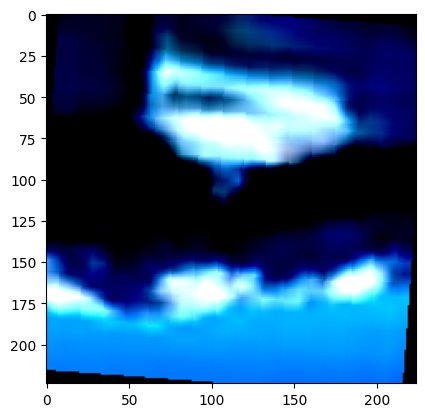

In [149]:
import matplotlib.pyplot as plt
plt.imshow(train[350][0].cpu().permute(1, 2, 0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.1351534].


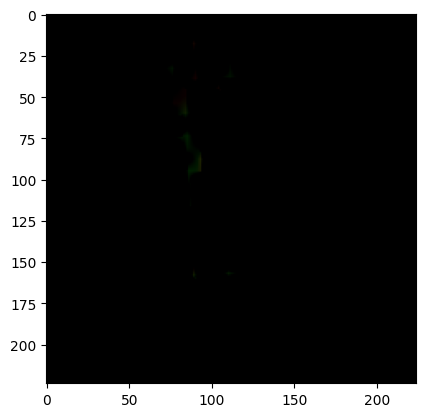

In [131]:
plt.imshow(train[10][0].cpu().permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.169412].


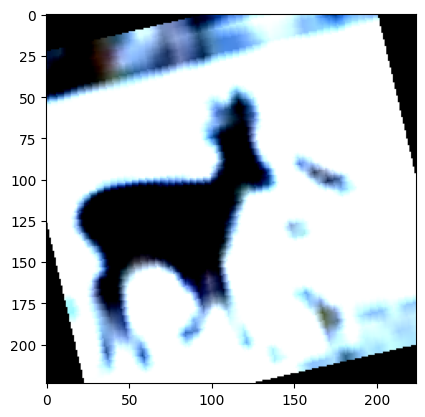

In [85]:
plt.imshow(train[20][0].cpu().permute(1, 2, 0))

Nastevení a reset seedů pro replikovatelnost, zřejmě bude možné zredukovat ...

In [54]:
reset_seed(42)

Definice učitelského modelu a jeho přepnutí do eval mode (nechceme trénovat a upravovat váhy, chceme pouze výstup)

In [55]:
##Vybere se daný "učitelský" model pro výpočet logitů

model = AutoModelForImageClassification.from_pretrained(
    "aaraki/vit-base-patch16-224-in21k-finetuned-cifar10",
    num_labels=10,
)
#model = AutoModelForImageClassification.from_pretrained(
#    "Ahmed9275/Vit-Cifar100",
#    num_labels=100,
#)

model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [56]:
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

### Metody pro načtení a uložení upravených souborů

Následně se vybere soubor, se kterým se pracuje. V případě CIFAR100 lze train část provést stejně jako test (veškerá data jsou v jednom souboru).

In [57]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def pickle_up(file, contents):
    with open(file, 'wb') as fo:
        pickle.dump(contents, fo, protocol=pickle.HIGHEST_PROTOCOL)

In [58]:
##Vybere se daný soubor, se kterým se pracuje

testing = unpickle("data/test/cifar-10-batches-py/test_batch")
#testing = unpickle("data/100-logits/cifar-100-python/test")
#testing = unpickle("data/100-logits/cifar-100-python/train")

In [59]:
logits_arr = []

In [ ]:
##Pro Cifar100 stačí pustit znovu pro train (není rozpadlý v souborech)

#for batch in tqdm(train_dataloader):
for batch in tqdm(test_dataloader):
    pixel_values, labels = batch
    with torch.no_grad():
        outputs = model(pixel_values)
        logits = outputs.logits
    logits_arr.append(logits.cpu().numpy())

  0%|          | 0/79 [00:00<?, ?it/s]

In [18]:
logits_arr_flat = []
data_arr_flat = []

In [19]:
for tensor in logits_arr:
    logits_arr_flat.extend(tensor)


In [20]:
testing[b"logits"] = logits_arr_flat

In [ ]:
##Vybere se daný soubor, kam se uloží logity

pickle_up("data/10-logits/cifar-10-batches-py/test_batch", testing) 
#pickle_up("data/100-logits/cifar-100-python/test", testing) 
#pickle_up("data/100-logits/cifar-100-python/train", testing) 

: 

: 

: 

## CIFAR10 
Loop pro CIFAR10, jelikož má rozpadnutou training část datasetu do separátních souborů.

In [61]:
#Pro Cifar10

reset_seed(42)
for index in range(1,5):
    data = unpickle(f"data/10/cifar-10-batches-py/data_batch_{index}")
    #train = CustomCIFAR10(root='./data/10', batch=index, train=True, transform=transform)
    train = CustomCIFAR10(root='./data/10', batch=index, train=True, transform=augment_transform)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=False)
    logits_arr = []
    for batch in tqdm(train_dataloader, desc = f"Progress for file {index}"): 
        pixel_values, labels = batch
        with torch.no_grad():
            outputs = model(pixel_values)
            logits = outputs.logits
        logits_arr.append(logits.cpu().numpy())
    logits_arr_flat = []
    for tensor in logits_arr:
        logits_arr_flat.extend(tensor)
    data[b"logits"] = logits_arr_flat
    #pickle_up(f"data/10-logits/cifar-10-batches-py/data_batch_{index}",data)
    pickle_up(f"data/10-logits/cifar-10-batches-py/data_batch_{index}{index}",data)

Progress for file 1:   0%|          | 0/157 [00:00<?, ?it/s]

Progress for file 2:   0%|          | 0/157 [00:00<?, ?it/s]

Progress for file 3:   0%|          | 0/157 [00:00<?, ?it/s]

Progress for file 4:   0%|          | 0/157 [00:00<?, ?it/s]